In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.3 -c pytorch

Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - cudatoolkit=11.3
    - pytorch
    - torchaudio
    - torchvision


The following NEW packages will be INSTALLED:

  bzip2              conda-forge/linux-64::bzip2-1.0.8-h7f98852_4
  ffmpeg             pytorch/linux-64::ffmpeg-4.3-hf484d3e_0
  gmp                conda-forge/linux-64::gmp-6.2.1-h58526e2_0
  gnutls             conda-forge/linux-64::gnutls-3.6.13-h85f3911_1
  lame               conda-forge/linux-64::lame-3.100-h7f98852_1001
  libiconv           conda-forge/linux-64::libiconv-1.17-h166bdaf_0
  nettle             conda-forge/linux-64::nettle-3.6-he412f7d_0
  openh264           conda-forge/linux-64::openh264-2.1.1-h780b84a_0
  torchaudio         pytorch/linux-64::torchaudio-0.11.0-py37_cu113
  torchvision        pytorch/linux-64::torchvision-0.12.0-py37_cu113

The following packages will be UPDATED:

  certifi                          2021.10.8-py37h89c1867_1 -->

In [2]:
%matplotlib inline

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms


transform = transforms.Compose([
     transforms.RandomHorizontalFlip(),
     transforms.RandomVerticalFlip(),
     transforms.RandomGrayscale(),
     transforms.ToTensor(),
     transforms.Normalize((0.50, 0.50, 0.50), (0.50, 0.50, 0.50))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True, num_workers=8,
                                            prefetch_factor = 2, 
                                            pin_memory = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=8,
                                             prefetch_factor = 2, 
                                            pin_memory = True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

Files already downloaded and verified


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Files already downloaded and verified


In [3]:
is_cuda=torch.cuda.is_available()
device=torch.device("cuda" if is_cuda else "cpu")
print(device)

cuda


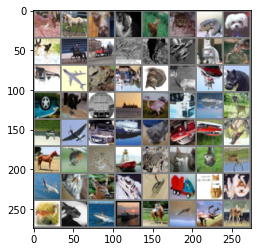

 deer horse   cat   dog  deer  frog  frog   dog  deer horse truck  frog horse plane   cat  deer truck plane  frog truck   cat  deer  ship horse   car   cat truck  ship  bird truck  ship  deer plane plane   car  ship   cat   car   car  bird horse  bird   cat  ship  frog   cat  bird  deer plane   cat  deer  ship  bird truck   cat   dog  deer   cat  ship  ship horse plane  deer  deer


In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Set first filter 
        self.conv1_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)

        # He initialization:
        nn.init.kaiming_uniform_(self.conv1_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv1_2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv1_2.weight, mode='fan_in', nonlinearity='relu')

        # Set second filter
        self.conv2_1 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_1.weight, mode='fan_in', nonlinearity='relu')

        self.conv2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv2_2.weight, mode='fan_in', nonlinearity='relu')

        # Set third filter
        self.conv3_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_1.weight, mode='fan_in', nonlinearity='relu')
        
        self.conv3_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        nn.init.kaiming_uniform_(self.conv3_2.weight, mode='fan_in', nonlinearity='relu')

        # Define proportion or neurons to dropout
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.3)
        self.dropout3 = nn.Dropout(0.4)
        self.dropout4 = nn.Dropout(0.5)

        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(2048, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_2(F.relu(self.conv1_1(x)))))
        x = self.pool(F.relu(self.conv2_2(F.relu(self.conv2_1(x)))))
        x = self.pool(F.relu(self.conv3_2(F.relu(self.conv3_1(x)))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


net = Net().to(device)

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


epoch = 100
TL = [0 for x in range(epoch)] #train loss
Tacc = [0 for x in range(epoch)] #train accuracy
VL = [0 for x in range(epoch)] #validation loss
Vacc = [0 for x in range(epoch)] #validation accuracy

for ep in range(epoch):  # loop over the dataset multiple times

    running_loss = 0.0
    train_acc = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs,labels=inputs.to(device),labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        train_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(50000))
        
    valid_loss = 0.0
    valid_acc = 0.0
    net.eval()     # Optional when not using Model Specific layer
    for inputs, labels in testloader:
        inputs,labels=inputs.to(device),labels.to(device)
        # Forward Pass
        outputs = net(inputs)
        # Find the Loss
        loss = criterion(outputs,labels)
        # Calculate Loss
        valid_loss += loss.item()

        pred=outputs.argmax(dim=1,keepdim=True)
        valid_acc += ((pred.eq(labels.view_as(pred)).sum().item())/(10000))

    TL[ep] = running_loss  
    Tacc[ep] = train_acc   
    VL[ep] = valid_loss
    Vacc[ep] = valid_acc

    print(f'Epoch {ep+1}/{epoch} \t Training Loss: {round(running_loss / len(trainloader),4)} \t Validation Loss: {round(valid_loss / len(testloader),4)} \t Training Accuracy: {round(train_acc,4)} \t Validation Accuracy:{round(valid_acc,4)}')

print('Finished Training')

Epoch 1/100 	 Training Loss: 1.9227 	 Validation Loss: 1.6674 	 Training Accuracy: 0.2985 	 Validation Accuracy:0.3866
Epoch 2/100 	 Training Loss: 1.5752 	 Validation Loss: 1.4832 	 Training Accuracy: 0.4254 	 Validation Accuracy:0.4605
Epoch 3/100 	 Training Loss: 1.4274 	 Validation Loss: 1.3748 	 Training Accuracy: 0.4854 	 Validation Accuracy:0.49
Epoch 4/100 	 Training Loss: 1.3313 	 Validation Loss: 1.3122 	 Training Accuracy: 0.5224 	 Validation Accuracy:0.5312
Epoch 5/100 	 Training Loss: 1.251 	 Validation Loss: 1.2819 	 Training Accuracy: 0.5515 	 Validation Accuracy:0.532
Epoch 6/100 	 Training Loss: 1.1758 	 Validation Loss: 1.2001 	 Training Accuracy: 0.584 	 Validation Accuracy:0.5703
Epoch 7/100 	 Training Loss: 1.1077 	 Validation Loss: 1.0954 	 Training Accuracy: 0.6065 	 Validation Accuracy:0.6142
Epoch 8/100 	 Training Loss: 1.0525 	 Validation Loss: 1.1027 	 Training Accuracy: 0.6288 	 Validation Accuracy:0.608
Epoch 9/100 	 Training Loss: 0.998 	 Validation Loss: 

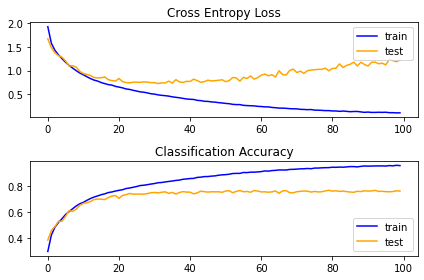

In [6]:
import sys
from matplotlib import pyplot
nTL= [x / len(trainloader) for x in TL]
nVL = [x / len(testloader) for x in VL]
# plot diagnostic learning curves
# plot loss
pyplot.subplot(211)
pyplot.title('Cross Entropy Loss')
pyplot.plot(nTL, color='blue', label='train')
pyplot.plot(nVL, color='orange', label='test')
pyplot.legend(loc="upper right")
# plot accuracy
pyplot.subplot(212)
pyplot.title('Classification Accuracy')
pyplot.plot(Tacc, color='blue', label='train')
pyplot.plot(Vacc, color='orange', label='test')
pyplot.legend(loc="lower right")
pyplot.tight_layout()
# save plot to file
# filename = sys.argv[0].split('/')[-1]
# pyplot.savefig(filename + '_plot.png')
# pyplot.close()


In [7]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data 
        images,labels=images.to(device),labels.to(device)
        outputs = net(images)    
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

# print accuracy for each class
overall_acc = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, 
                                                   accuracy))

Accuracy for class plane is: 79.1 %
Accuracy for class car   is: 85.4 %
Accuracy for class bird  is: 67.2 %
Accuracy for class cat   is: 54.0 %
Accuracy for class deer  is: 76.1 %
Accuracy for class dog   is: 64.6 %
Accuracy for class frog  is: 87.6 %
Accuracy for class horse is: 77.9 %
Accuracy for class ship  is: 86.4 %
Accuracy for class truck is: 88.8 %
